In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/numpy-data/sentence_data_array.npy
/kaggle/input/numpy-data/caption_data_array.npy
/kaggle/input/flickr8k/captions.txt
/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg
/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg
/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg
/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg
/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg
/kaggle/input/flickr8k/Images/2752809449_632cd991b3.jpg
/kaggle/input/flickr8k/Images/3097776588_312932e438.jpg
/kaggle/input/flickr8k/Images/1206506157_c7956accd5.jpg
/kaggle/input/flickr8k/Images/1319634306_816f21677f.jpg
/kaggle/input/flickr8k/Images/2465218087_fca77998c6.jpg
/kaggle/input/flickr8k/Images/3351493005_6e5030f596.jpg
/kaggle/input/flickr8k/Images/2949337912_beba55698b.jpg
/kaggle/input/flickr8k/Images/534886684_a6c9f40fa1.jpg
/kaggle/input/flickr8k/Images/3543600125_223747ef4c.jpg
/kaggle/input/flickr8k/Images/2174206711_11cb712a8d.jpg
/kaggle/input/flickr8k/Images

In [3]:
# !pip install -q tensorflow==2.16.1 tensorflow-text==2.16.1

In [4]:
import kagglehub
path = kagglehub.dataset_download("adityajn105/flickr8k")
path

'/kaggle/input/flickr8k'

In [5]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Embedding , Dropout
from tensorflow.keras.layers import LSTM,add,LeakyReLU,Reshape,GRU,concatenate,Add,BatchNormalization,SimpleRNN,GlobalAveragePooling2D,Bidirectional,Conv2D , MaxPooling2D,Flatten,Input,TextVectorization,Normalization,Rescaling
from tensorflow.keras.datasets import imdb
from tensorflow.keras.metrics import F1Score,AUC
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from glob import glob
import os
import csv
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt

In [6]:
print(tf.__version__)

2.18.0


In [7]:
# import tensorflow as tf

# try:
#     # Use 'local' for TPU v5e (TPU VM)
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local') 
#     print('Device:', tpu.master())

#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
    
#     strategy = tf.distribute.TPUStrategy(tpu)
#     print('Number of replicas:', strategy.num_replicas_in_sync)

# except ValueError:
#     print("TPU not found. Defaulting to CPU/GPU.")
#     strategy = tf.distribute.get_strategy()


In [8]:

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print("GPU detected:", gpus)
else:
    print("No GPU detected")

print("\nDetailed devices:")
print(tf.config.list_physical_devices())

GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Detailed devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
os.listdir()

['.virtual_documents']

In [10]:
# file_text=''
# with open(path+'/captions.txt','r') as file:
#   lines = file.readlines()
# with open('./caption.csv','w', newline='') as file_csv:
#      writering=csv.writer(file_csv)
#      for line in lines:
#         parts = line.strip().split(',', 1)
#         writering.writerow(parts)

In [11]:
def load_data(caption):
    with open(caption,'r') as file:
        return file.read()

doc=load_data('/kaggle/input/flickr8k/captions.txt')

captions={}

for i in doc.split('\n'):
    if len(i) < 2:
        continue
    if ',' not in i:
        continue
    image_id,caption=i.split(",",1)
    caption=caption.lower().strip()
    caption=caption.replace('.','')
    caption="startseq" + caption + "endseq"
    if image_id not in captions:
        captions[image_id] = []
    captions[image_id].append(caption)
    


In [12]:
captions

{'image': ['startseqcaptionendseq'],
 '1000268201_693b08cb0e.jpg': ['startseqa child in a pink dress is climbing up a set of stairs in an entry way endseq',
  'startseqa girl going into a wooden building endseq',
  'startseqa little girl climbing into a wooden playhouse endseq',
  'startseqa little girl climbing the stairs to her playhouse endseq',
  'startseqa little girl in a pink dress going into a wooden cabin endseq'],
 '1001773457_577c3a7d70.jpg': ['startseqa black dog and a spotted dog are fightingendseq',
  'startseqa black dog and a tri-colored dog playing with each other on the road endseq',
  'startseqa black dog and a white dog with brown spots are staring at each other in the street endseq',
  'startseqtwo dogs of different breeds looking at each other on the road endseq',
  'startseqtwo dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8.jpg': ['startseqa little girl covered in paint sits in front of a painted rainbow with her hands in a bowl endse

In [13]:
def create_tokenizer(descriptions):
    token=Tokenizer(num_words=50000,oov_token="<unk>")
    lines=[]
    for key in descriptions.keys():
        [lines.append(d) for d in descriptions[key]]
    token.fit_on_texts(lines)
    return token

In [14]:
tokenizer=create_tokenizer(captions)
tokenizer.word_index

{'<unk>': 1,
 'a': 2,
 'endseq': 3,
 'startseqa': 4,
 'in': 5,
 'the': 6,
 'on': 7,
 'is': 8,
 'and': 9,
 'dog': 10,
 'with': 11,
 'man': 12,
 'of': 13,
 'startseqtwo': 14,
 'white': 15,
 'black': 16,
 'are': 17,
 'boy': 18,
 'woman': 19,
 'girl': 20,
 'to': 21,
 'wearing': 22,
 'startseqthe': 23,
 'at': 24,
 'red': 25,
 'water': 26,
 'startseq': 27,
 'brown': 28,
 'young': 29,
 'people': 30,
 'his': 31,
 'blue': 32,
 'dogs': 33,
 'running': 34,
 'through': 35,
 'playing': 36,
 'while': 37,
 'shirt': 38,
 'an': 39,
 'down': 40,
 'standing': 41,
 'ball': 42,
 'little': 43,
 'grass': 44,
 'child': 45,
 'snow': 46,
 'jumping': 47,
 'over': 48,
 'person': 49,
 'front': 50,
 'sitting': 51,
 'two': 52,
 'holding': 53,
 'up': 54,
 'by': 55,
 'green': 56,
 'small': 57,
 'yellow': 58,
 'large': 59,
 'field': 60,
 'group': 61,
 'her': 62,
 'walking': 63,
 'into': 64,
 'startseqthree': 65,
 'men': 66,
 'air': 67,
 'near': 68,
 'children': 69,
 'one': 70,
 'jumps': 71,
 'beach': 72,
 'another': 73

In [15]:
def creating_traing_data(descriptions, photos, tokenizer, max_length, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while True:
        for key, desc_list in descriptions.items():
            if key not in photos:
                continue
            n += 1
            photo = photos[key]

            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq = seq[:i]
                    out_word = seq[i]
                    in_seq = sequence.pad_sequences([in_seq], maxlen=max_length,padding='post')[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_word)


            if n == batch_size:

                yield ((np.array(X1), np.array(X2)), np.array(y))
                X1, X2, y = list(), list(), list()
                n = 0

In [16]:
max_len=40
def  caption_to_pad(capt):
    seq=token.texts_to_sequences([capt])[0]
    return sequence.pad_sequences([seq],maxlen=max_len)
    
    
    

In [28]:
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input

In [29]:

def load_and_preprocess(image_path):
    img = plt.imread(image_path)
    img=cv.resize(img,(299,299))
    img=preprocess_input(img)
    return np.array(img)

In [ ]:
name_of_img='1000268201_693b08cb0e.jpg'
load_and_preprocess(f'/kaggle/input/flickr8k/Images/{name_of_img}').shape

In [ ]:
name_of_img='1000268201_693b08cb0e.jpg'
plt.imshow(load_and_preprocess(f'/kaggle/input/flickr8k/Images/{name_of_img}'))

In [36]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3

In [30]:
def inceptions():
    input_ince=Input(shape=(299,299,3))
    inceptions_models=InceptionV3(include_top=False,input_tensor=input_ince )
    inceptions_models.trainable=False 
    
    x=inceptions_models.output
    x=GlobalAveragePooling2D()(x)
    
    inception=Model(inputs=[inceptions_models.input],outputs=[x])
    return inception
    

In [31]:
model_incep=inceptions()
model_incep.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 147, 147,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 147, 147,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 73, 73,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 73, 73,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 71, 71,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

In [32]:
def extract_features(dictionary, model):
    features = {}
    for img_id in dictionary.keys():
        if 'image' in img_id:
            continue
        img_path = os.path.join(path, 'Images', img_id)
        image = load_and_preprocess(img_path)
        
        feature_vectors = model.predict(np.expand_dims(image, 0), verbose=0)[0]
        features[img_id] = feature_vectors
    return features

vector_f=extract_features(captions,model_incep)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_312']]
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)
I0000 00:00:1768066374.686872     123 service.cc:148] XLA service 0x7c3708005320 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768066374.687564     123 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768066375.614931     123 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1768066379.572275     123 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [43]:
vector_f['1000268201_693b08cb0e.jpg']

array([0.10082328, 0.26438767, 0.88368905, ..., 0.30874676, 0.4238762 ,
       0.40128773], dtype=float32)

In [42]:
len(vector_f['1000268201_693b08cb0e.jpg'])

2048

In [21]:

# def build_feature_model():
#  input_cnn=Input(shape=(224,224,3))
#  model = VGG16(weights='imagenet', include_top=True)

#  model.trainable=False

#  feature_model =Model(inputs=model.input, outputs=model.get_layer('fc2').output)

#  return feature_model


In [22]:
# model_cnn=build_feature_model()

I0000 00:00:1768046743.172988      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [23]:
# model_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 134,260,544 (512.16 MB)

In [24]:
# def extract_all_features(dictionary, model):
#     features = {}
#     for img_id in dictionary.keys():
#         if 'image' in img_id:
#             continue
#         img_path = os.path.join(path, 'Images', img_id)
#         image = load_and_preprocess(img_path)
        
#         feature_vectors = model.predict(np.expand_dims(image, 0), verbose=0)[0]
#         features[img_id] = feature_vectors
#     return features

# vector_f=extract_all_features(captions,model_cnn)

I0000 00:00:1768046760.473817     121 service.cc:148] XLA service 0x7ce170004100 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768046760.474616     121 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768046760.602410     121 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1768046762.209631     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [ ]:
len(vector_f['1000268201_693b08cb0e.jpg'])

In [ ]:
print('hello')

In [34]:

def perplexity(y_true, y_pred):
    loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true, y_pred
    )
    return tf.exp(tf.reduce_mean(loss))


def defintion_model(vocab_s,max_lenght):
    input_1=Input(shape=(2048,))
    fe2 = Dense(512, activation='relu')(input_1)
    reshape=Reshape((1,512),input_shape=(512,))(fe2)
    
    inputs2=Input(shape=(max_lenght,))    
    x=Embedding(vocab_s,512,mask_zero=False)(inputs2)
    x=Dropout(0.5)(x)
    merged=concatenate([reshape,x],axis=1)
    
    x= LSTM(512,dropout=0.5)(merged)
    
    x=add([x,fe2])
    x=Dropout(0.5)(x)
    
    output_lstm=Dense(vocab_s,activation='softmax')(x)
    
    model_rnn=Model(inputs=[input_1,inputs2],outputs=output_lstm)
    
    model_rnn.compile(optimizer='adam',loss='sparse_categorical_crossentropy')
    return model_rnn

In [35]:
vocab_size=len(tokenizer.word_index)+1
model=defintion_model(vocab_size,max_len)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [36]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  1,049,088 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 40, 512)   │  5,054,464 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 512)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 40, 512)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 41, 512)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 512)       │  2,099,200 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 512)       │          0 │ lstm[0][0],       │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 9872)      │  5,064,336 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,267,088 (50.61 MB)

 Trainable params: 13,267,088 (50.61 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
max_length=max_len
batch_size=16
steps=len(captions)//batch_size
# generator=creating_traing_data(captions, vector_f, tokenizer, max_len, batch_size)
generator = creating_traing_data(captions, vector_f, tokenizer, max_len, batch_size)

In [133]:
model.fit(generator,epochs=10,batch_size=batch_size,steps_per_epoch=steps)

Epoch 1/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 49s 97ms/step - loss: 2.0758
Epoch 2/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 49s 98ms/step - loss: 2.0702
Epoch 3/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - loss: 2.0747
Epoch 4/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 49s 98ms/step - loss: 2.0668
Epoch 5/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - loss: 2.0612
Epoch 6/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - loss: 2.0576
Epoch 7/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 49s 98ms/step - loss: 2.0581
Epoch 8/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 49s 98ms/step - loss: 2.0613
Epoch 9/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 50s 98ms/step - loss: 2.0603
Epoch 10/10
505/505 ━━━━━━━━━━━━━━━━━━━━ 49s 98ms/step - loss: 2.1300


In [134]:
# images=glob(path+'/Images/*.jpg')

In [135]:
def index_to_word(index):
    for word, idx in tokenizer.word_index.items():
        if idx == index:
            return word
    return None

In [136]:
sent=[]
def genration_caption(image_path):
    image=load_and_preprocess(image_path)
    image=tf.expand_dims(image, 0)
    feature=model_incep.predict(image,verbose=1)
    
    caption=['startseq']
    
    for _ in range(max_len):
        seq = tokenizer.texts_to_sequences([caption])[0]
        seq =sequence.pad_sequences([seq], maxlen=max_len)
        
        rnn_y= model.predict([feature, seq], verbose=0)
        
        next_word_id = np.argmax(rnn_y)
        
        word=index_to_word(next_word_id)
        
        if word is None:
            break

        caption.append(word)

        if word == "endseq":
            break

    return " ".join(caption[1:-1])
        

    

In [137]:
# import numpy as np

# def beam_search_caption(photo_features, beam_size=3):
#     image=load_and_preprocess(photo_features)
#     image=tf.expand_dims(image, 0)
#     feature=model_incep.predict(image,verbose=1)
    
#     sequences = [[['start'], 0.0]]  # (sentence, score)

#     for _ in range(max_len):
#         all_candidates = []

#         for seq, score in sequences:
#             if seq[-1] == 'end':
#                 all_candidates.append((seq, score))
#                 continue

#             encoded = tokenizer.texts_to_sequences([' '.join(seq)])[0]
#             encoded = sequence.pad_sequences([encoded], maxlen=max_len,padding='post')

#             preds = model.predict([feature, encoded], verbose=0)
#             last_word_logits = preds[0, -1, :]
#             top_k=last_word_logits.argsort()[-beam_size:]
#             # top_k = np.argsort(preds)[-beam_size:]

#             for word_idx in top_k:
#                 word = tokenizer.index_word.get(word_idx.item())
#                 if word is None:
#                     continue
#                 candidate = seq + [word]
#                 candidate_score =(score * len(seq) + last_word_logits[word_idx]) / (len(seq) + 1)
#                 # candidate_score = score - np.log(preds[word_idx] + 1e-9)
#                 all_candidates.append((candidate, candidate_score))
        
#         sequences = sorted(all_candidates,reverse=True, key=lambda x: x[1])[:beam_size]
                
#     return ' '.join(sequences[0][0])


In [147]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [155]:
def beam_search_caption(photo_features, beam_size=3):
    image=load_and_preprocess(photo_features)
    image=tf.expand_dims(image, axis=0)
    feature=model_incep.predict(image,verbose=1)

    sequences = [[['startseq'], 0.0]]  # (sentence, score)

    for _ in range(max_len):
        all_candidates = []

        for seq, score in sequences:
            if seq[-1] == 'endseq':
                all_candidates.append((seq, score))
                continue

            encoded = tokenizer.texts_to_sequences([' '.join(seq)])[0]
            encoded = sequence.pad_sequences([encoded], maxlen=max_len,padding='post')

            preds = model.predict([feature, encoded], verbose=0)[0]

            top_k = np.argsort(preds)[-beam_size:]

            for word_idx in top_k:
                word = tokenizer.index_word.get(word_idx)
                if word is None:
                    continue
                candidate = seq + [word]
                candidate_score = score - np.log(preds[word_idx] + 1e-9)
                all_candidates.append((candidate, candidate_score))

        sequences = sorted(all_candidates, key=lambda x: x[1])[:beam_size]

    return ' '.join(sequences[0][0])

In [156]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# def beam_search(image_path, beam_size=3):
#     # 1. تجهيز الصورة
#     image = load_and_preprocess(image_path)
#     image = tf.expand_dims(image, 0)
#     feature = model_cnn.predict(image, verbose=0)
    
#     # 2. تجهيز البداية
#     start_word = 'start'
#     end_word = 'end'
    
#     # التأكد من التوكن الصحيح
#     if start_word not in tokenizer.word_index:
#         start_word = '<start>' 
#     if end_word not in tokenizer.word_index:
#         end_word = '<end>'

#     start_seq = [tokenizer.word_index[start_word]]
    
#     # القائمة: [[list_of_indices], score]
#     sequences = [[start_seq, 0.0]]
    
#     # 3. حلقة البحث
#     for i in range(max_len):
#         all_candidates = []
        
#         for seq, score in sequences:
#             # لو الجملة انتهت بـ end، احتفظ بها كما هي
#             if seq[-1] == tokenizer.word_index[end_word]:
#                 all_candidates.append([seq, score])
#                 continue
            
#             # التنبؤ بالكلمة التالية
#             padded_seq = pad_sequences([seq], maxlen=max_len, padding='post') # جرب post لو pre مش نافع
#             pred = model.predict([feature, padded_seq], verbose=0)[0]
            
#             # ترتيب الاحتمالات
#             log_preds = np.log(pred + 1e-20)
#             top_indices = np.argsort(log_preds)[-beam_size:] 
            
#             for word_index in top_indices:
#                 # --- [FIX HERE] ---
#                 # منع التكرار: لا تختر الكلمة إذا كانت هي نفسها الكلمة السابقة
#                 if word_index == seq[-1]:
#                     continue
#                 # ------------------
                
#                 new_seq = seq + [word_index]
#                 new_score = score + log_preds[word_index]
#                 all_candidates.append([new_seq, new_score])
        
#         # اختيار أفضل مسارات
#         if not all_candidates: # لو القائمة فارغة وقف
#             break
            
#         sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_size]
        
#         # التوقف لو كل المسارات انتهت بـ end
#         count_finished = sum([1 for seq, score in sequences if seq[-1] == tokenizer.word_index[end_word]])
#         if count_finished == beam_size:
#             break

#     # 4. تحويل الأرقام لنصوص
#     best_seq = sequences[0][0]
#     final_caption = []
#     for idx in best_seq:
#         word = tokenizer.index_word[idx]
#         if word == end_word:
#             break
#         if word != start_word:
#             final_caption.append(word)
            
#     return ' '.join(final_caption)

In [157]:
name_of_img='1119418776_58e4b93eac.jpg'

In [158]:
captions['1000268201_693b08cb0e.jpg']

['startseqa child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseqa girl going into a wooden building endseq',
 'startseqa little girl climbing into a wooden playhouse endseq',
 'startseqa little girl climbing the stairs to her playhouse endseq',
 'startseqa little girl in a pink dress going into a wooden cabin endseq']

In [159]:
genration_caption(f'/kaggle/input/flickr8k/Images/{name_of_img}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


'and dogs dog dog dogs dog and in and and dog and and dog dog and and one black dog in and the running in in a the its and the the the this the in'

In [160]:
beam_search_caption(f'/kaggle/input/flickr8k/Images/{name_of_img}',10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


'startseq a black and white dog is running through the grass endseq'

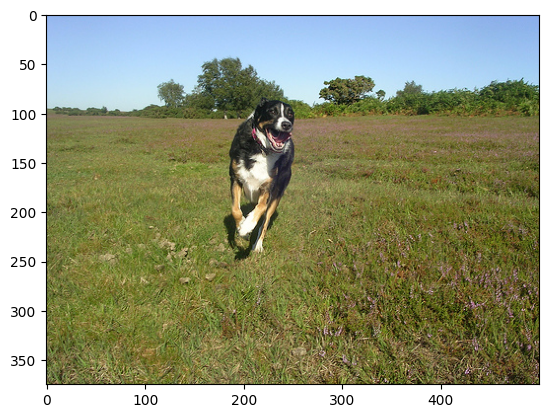

In [151]:
plt.imshow(plt.imread(f'/kaggle/input/flickr8k/Images/{name_of_img}'))

In [145]:
keys_dic=list(captions.keys())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


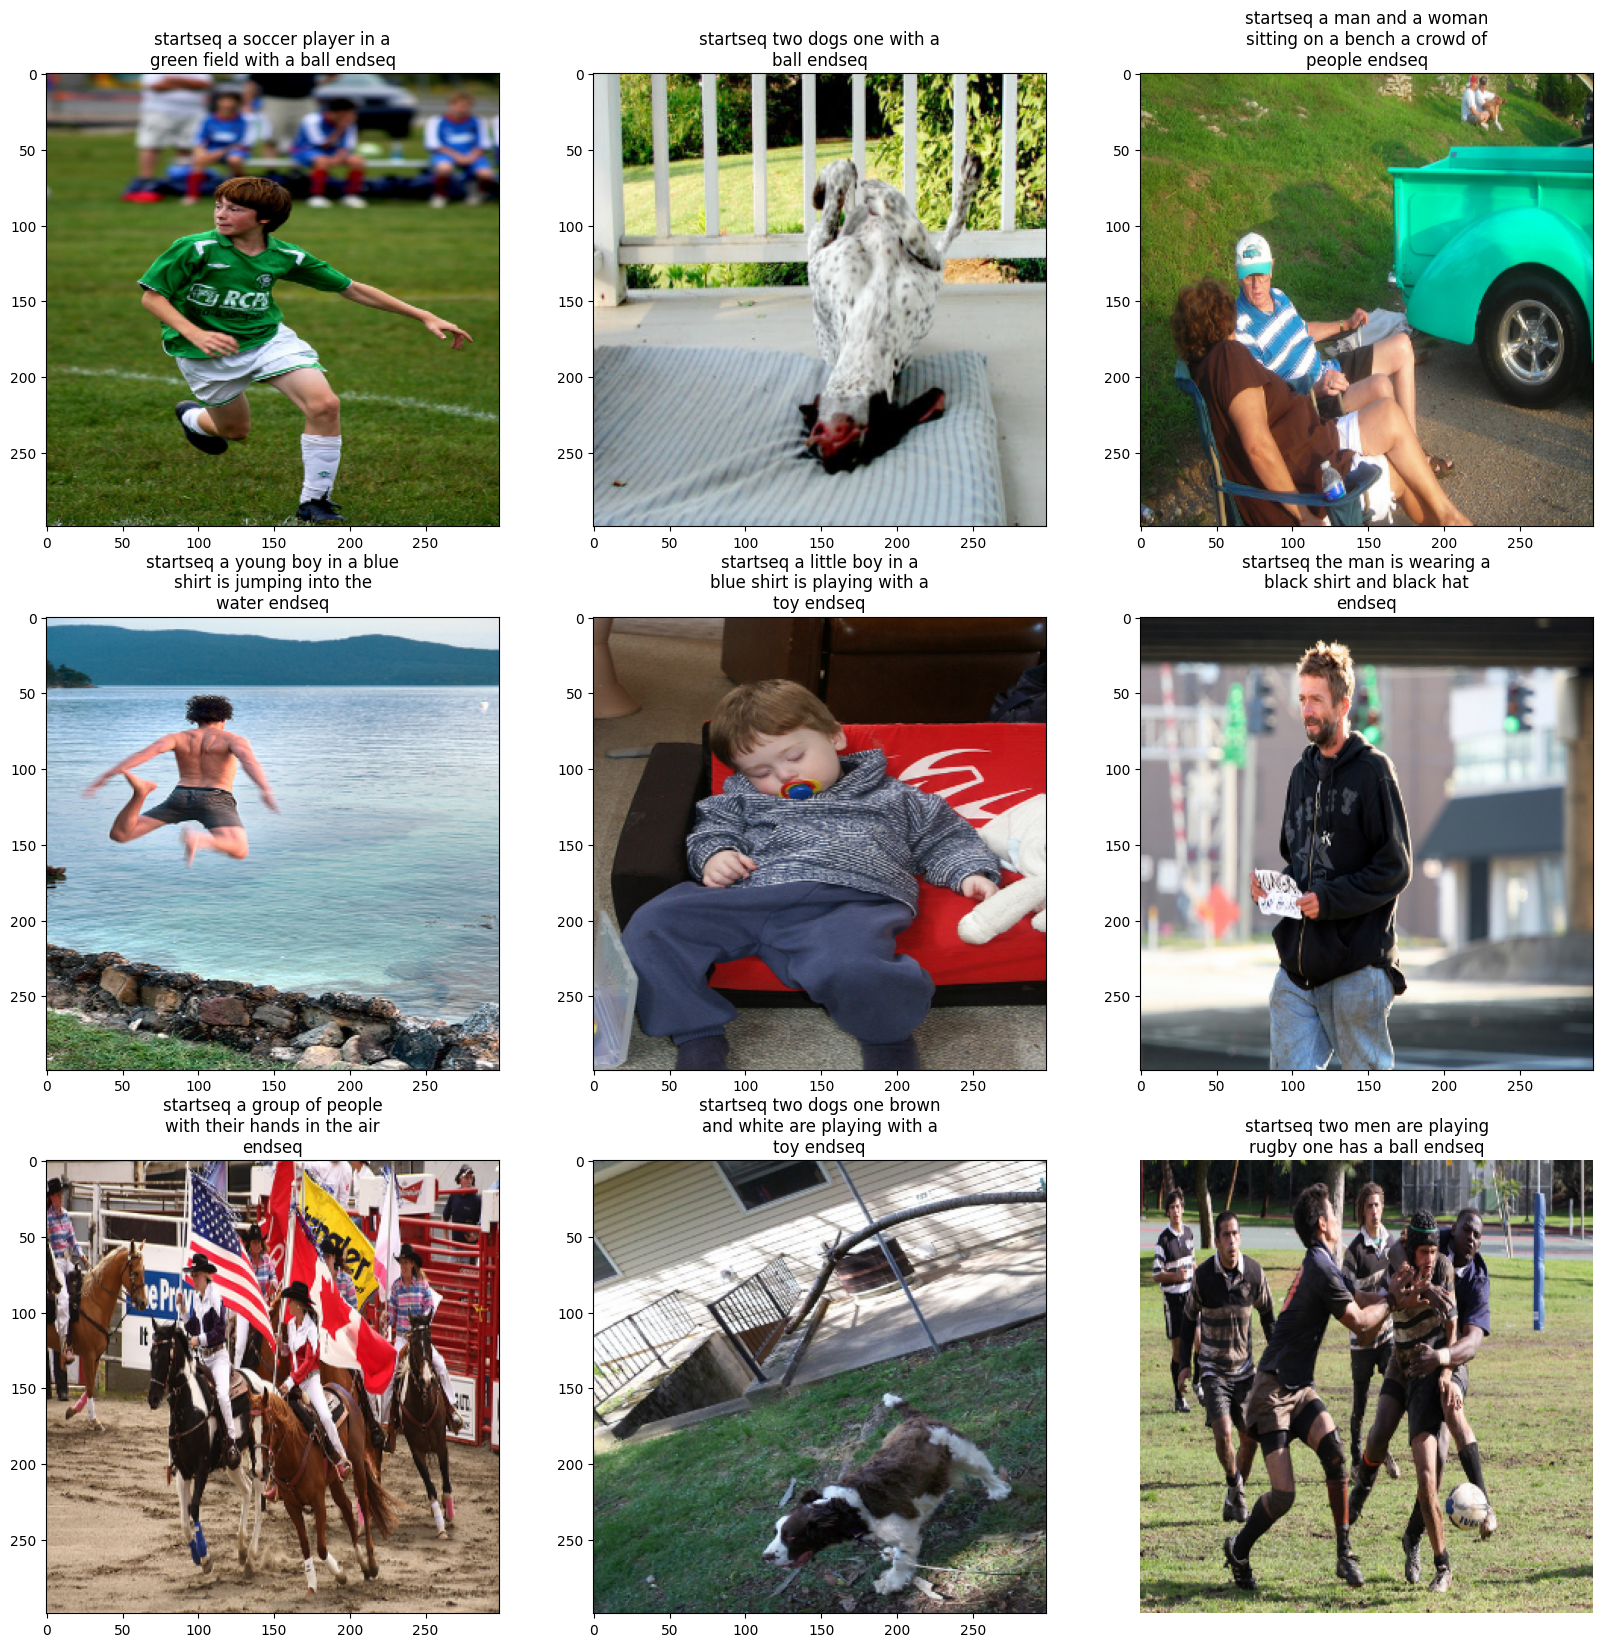

In [162]:
import random
import textwrap
%matplotlib inline

pathing='/kaggle/input/flickr8k/Images/'
figer,axis=plt.subplots(3,3,figsize=(20,20))
flatten=axis.flatten()
random.shuffle(keys_dic)
for i,k in enumerate(flatten):
    if keys_dic[i] == 'image':
        continue 
    pred=beam_search_caption(pathing+keys_dic[i],10)
    read_image=plt.imread(pathing+keys_dic[i])
    resizeing=cv.resize(read_image,(299,299))
    captioning='\n'.join(textwrap.wrap(pred,width=30))
    k.imshow(resizeing)
    k.set_title(captioning)
plt.axis('off') 
plt.show() 
 
    




In [102]:
captions

{'image': ['startseqcaptionendseq'],
 '1000268201_693b08cb0e.jpg': ['startseqa child in a pink dress is climbing up a set of stairs in an entry way endseq',
  'startseqa girl going into a wooden building endseq',
  'startseqa little girl climbing into a wooden playhouse endseq',
  'startseqa little girl climbing the stairs to her playhouse endseq',
  'startseqa little girl in a pink dress going into a wooden cabin endseq'],
 '1001773457_577c3a7d70.jpg': ['startseqa black dog and a spotted dog are fightingendseq',
  'startseqa black dog and a tri-colored dog playing with each other on the road endseq',
  'startseqa black dog and a white dog with brown spots are staring at each other in the street endseq',
  'startseqtwo dogs of different breeds looking at each other on the road endseq',
  'startseqtwo dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8.jpg': ['startseqa little girl covered in paint sits in front of a painted rainbow with her hands in a bowl endse

In [100]:
# plt.imshow(load_and_preprocess(f'/kaggle/input/flickr8k/Images/{name_of_img}'))

In [166]:

from nltk.translate.bleu_score import sentence_bleu

def refernce(image,caption=captions):
    raw_captions=caption.get(image,[])
    refernce=[]
    for cap in raw_captions:
        li1=[ word for word in cap.split() if word not in ['startseqa', 'endseq']]
        refernce.append(li1)

    return refernce

lists_Bleu=[]
for i in range(1,6):
    if keys_dic[i] == 'image':
        continue 
    ref=refernce(keys_dic[i])
    pred_y=beam_search_caption(f'/kaggle/input/flickr8k/Images/{keys_dic[i]}',10)
    candidate=[ token for token in pred_y.split() if token not in ['startseqa', 'endseq']]
    Bleu=sentence_bleu(ref,candidate,weights=[0.5,0.5])
    lists_Bleu.append(Bleu)
    
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [167]:

lists_Bleu

[5.637975647982813e-155,
 0.4688072309384954,
 0.21320071635561047,
 0.35675303400633784,
 0.22140372138502384]

In [168]:
model.save('./caption_model_v1_1_1.h5')
model.save('./caption_model_v1.1.1_keras.keras')
model_incep.save('./InceptionEF_model.h5')




